In [10]:
import os, sys
sys.path.append(os.path.abspath(".."))
# Adjust path for src/

from config import model_config, data_config  # ✅ absolute import

from model_utils import ModelUtils
from data_preprocessing import prepare_data_for_training


Loading IMDB dataset...


python(99107) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Getting predictions:   0%|          | 0/1563 [00:00<?, ?it/s]


Overall Metrics:
Accuracy: 0.8744
Precision: 0.8746
Recall: 0.8744
F1 Score: 0.8743


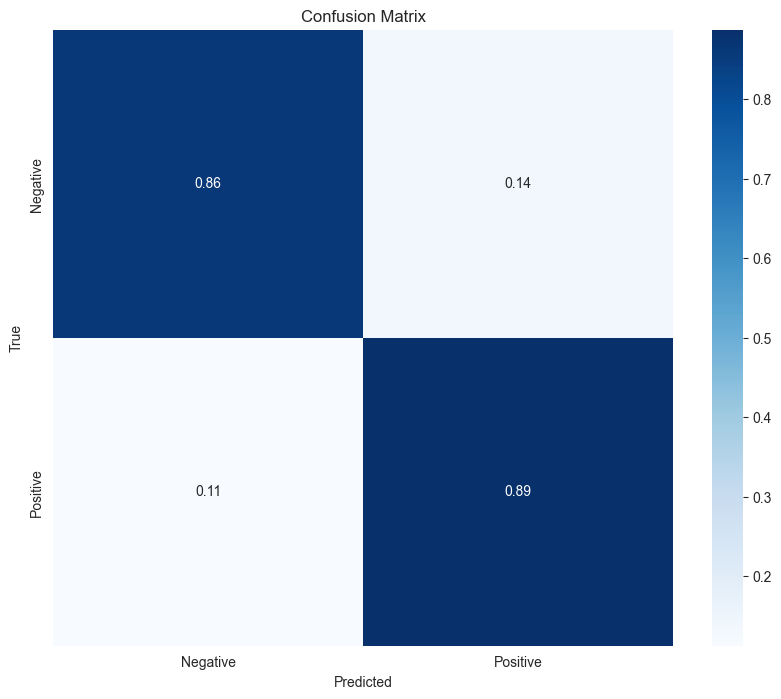

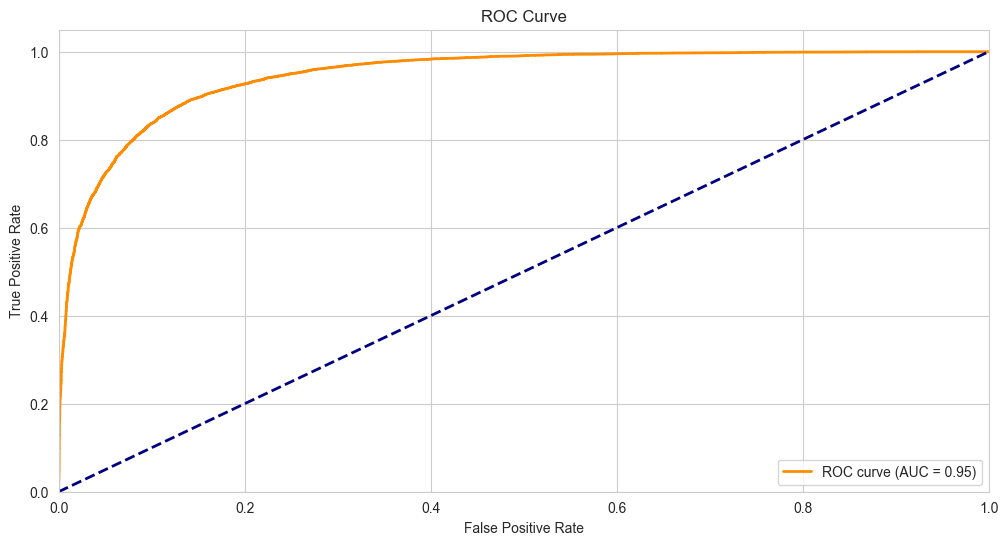

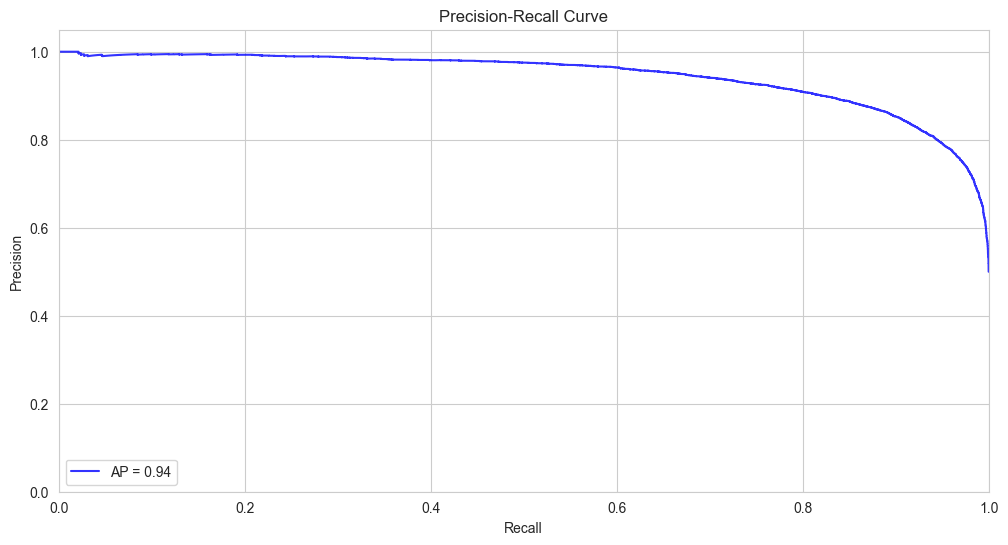

KeyError: "Column text not in the dataset. Current columns in the dataset: ['label', 'input_ids', 'attention_mask']"

In [13]:
# IMDB Sentiment Analysis - Evaluation and Analysis

# Import required libraries
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Import project modules
from src.config import model_config, data_config
from src.data_preprocessing import prepare_data_for_training
from src.evaluation import (
    plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve,
    analyze_errors, save_evaluation_report
)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

# Load model & tokenizer from saved directory (safetensors / config.json)
model = AutoModelForSequenceClassification.from_pretrained(model_config.output_dir)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


# Prepare test data
_, _, test_dataset, _ = prepare_data_for_training()
test_loader = DataLoader(
    test_dataset,
    batch_size=model_config.batch_size,
    shuffle=False,
    num_workers=0
)

# Get predictions
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting predictions"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

# Make predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
preds, probs, labels = get_predictions(model, test_loader, device)

# Calculate metrics
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average='weighted', zero_division=0)
recall = recall_score(labels, preds, average='weighted', zero_division=0)
f1 = f1_score(labels, preds, average='weighted', zero_division=0)

# Print overall metrics
print(f"\nOverall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
plot_confusion_matrix(
    labels, 
    preds, 
    class_names=['Negative', 'Positive'], 
    title='Confusion Matrix',
    save_path=os.path.join(model_config.output_dir, 'confusion_matrix.png')
)

# Plot ROC curve
roc_auc = plot_roc_curve(
    labels, 
    probs[:, 1], 
    title='ROC Curve',
    save_path=os.path.join(model_config.output_dir, 'roc_curve.png')
)

# Plot Precision-Recall curve
avg_precision = plot_precision_recall_curve(
    labels, 
    probs[:, 1], 
    title='Precision-Recall Curve',
    save_path=os.path.join(model_config.output_dir, 'precision_recall_curve.png')
)

# Generate detailed error analysis
error_analysis = analyze_errors(
    test_dataset['text'],
    labels,
    preds,
    probs[:, 1],
    label_names=['Negative', 'Positive'],
    num_examples=5
)

# Save evaluation report
report_path = save_evaluation_report(
    error_analysis,
    model_config.output_dir,
    'evaluation_report.json'
)

# Print error analysis
print("\nError Analysis:")
print(f"Total examples: {error_analysis['statistics']['total_examples']}")
print(f"Correct predictions: {error_analysis['statistics']['correct_predictions']}")
print(f"Incorrect predictions: {error_analysis['statistics']['incorrect_predictions']}")
print(f"Accuracy: {error_analysis['statistics']['accuracy']:.4f}")
print(f"Precision: {error_analysis['statistics']['precision']:.4f}")
print(f"Recall: {error_analysis['statistics']['recall']:.4f}")
print(f"F1 Score: {error_analysis['statistics']['f1_score']:.4f}")
print(f"False positives: {error_analysis['statistics']['false_positives_count']}")
print(f"False negatives: {error_analysis['statistics']['false_negatives_count']}")
print(f"Uncertain predictions: {error_analysis['statistics']['uncertain_predictions_count']}")
print(f"Average confidence: {error_analysis['statistics']['average_confidence']:.4f}")
print(f"Average confidence (correct): {error_analysis['statistics']['average_confidence_correct']:.4f}")
print(f"Average confidence (incorrect): {error_analysis['statistics']['average_confidence_incorrect']:.4f}")

# Display examples of error types
print("\nFalse Positives (Predicted Positive, Actually Negative):")
for example in error_analysis['error_analysis']['false_positives']:
    print(f"\nText: {example['text']}")
    print(f"True label: {example['true_label']}")
    print(f"Predicted label: {example['pred_label']}")
    print(f"Confidence: {example['confidence']:.4f}")
    print(f"Positive probability: {example['prob_positive']:.4f}")

print("\nFalse Negatives (Predicted Negative, Actually Positive):")
for example in error_analysis['error_analysis']['false_negatives']:
    print(f"\nText: {example['text']}")
    print(f"True label: {example['true_label']}")
    print(f"Predicted label: {example['pred_label']}")
    print(f"Confidence: {example['confidence']:.4f}")
    print(f"Positive probability: {example['prob_positive']:.4f}")

print("\nUncertain Predictions:")
for example in error_analysis['error_analysis']['uncertain_predictions']:
    print(f"\nText: {example['text']}")
    print(f"True label: {example['true_label']}")
    print(f"Predicted label: {example['pred_label']}")
    print(f"Confidence: {example['confidence']:.4f}")
    print(f"Positive probability: {example['prob_positive']:.4f}")
